<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 28px; color: black; font-weight: bold;">
A neural ODE toy model
</div>

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import timeit
from torch.distributions import Normal, Independent, kl_divergence, MultivariateNormal
from torchdiffeq import odeint, odeint_adjoint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [26]:
def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything()

In [27]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float32)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 4090
Total GPU Memory: 23.6 GB


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 28px; color: black; font-weight: bold;">
Data
</div>

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 16px; color: black; font-weight: bold;">
Ground truth
</div>

In [28]:
class SpiralFlow(nn.Module):
    """
    Defines the gradient flow of the 2D Spiral as a nn.Module to be used in odeint_adjoint from torchdiffeq
    Inputs:
        - t (scalar tensor): time. Here, the flow is time-invariant, so t is not used. However it is required by the ODE solver.
        - x (tensor of shape (2,)): current position in the 2D plane.
        - mu (float): parameter of the spiral.
    Outputs:
        - x_dot (tensor of shape (2,)): time derivative of the position.
    """
    def __init__(self, mu=0.01):
        super(SpiralFlow, self).__init__()
        self.mu = mu

    def forward(self, t, x):
        x1, x2 = x[0], x[1]
        r  = x1**2 + x2**2
        x1_dot = self.mu * x1 - x2 - x1 * r
        x2_dot = x1 + self.mu * x2 - x2 * r
        return torch.stack([x1_dot, x2_dot])
    
spiral_flow = SpiralFlow().to(device)

x = torch.tensor([2., 0.], device=device, requires_grad=True)
t = torch.tensor([10.], device=device)
dx = spiral_flow(t, x)
print(dx)

tensor([-7.9800,  2.0000], device='cuda:0', grad_fn=<StackBackward0>)


Trajectory parameters

In [29]:
# starting point
x0 = torch.tensor([2.0, 0.0], dtype=torch.float, requires_grad=True).to(device)

# number of points in the trajectory
n_steps = 1000

# time span
t_start = 0.0
t_end = 20.0
ts = torch.linspace(t_start, t_end, n_steps).to(device)

In [30]:
# compute the trajectory
gt_trajectory = odeint_adjoint(spiral_flow, x0, ts, rtol=1e-2, atol=1e-2, method='rk4')

# compute gradients along the trajectory
gradients = []
x = x0.detach().to(device)

for t,x in zip(ts, gt_trajectory):
    gradients.append(spiral_flow(t,x).detach().cpu().numpy())
    
gt_gradients = torch.tensor(np.array(gradients)).to(device)

In [31]:
def plot_trajectory_2D(ts, trajectory, gradients, sampled_ts=None, sampled_trajectory=None, sampled_gradients=None, interval=5, scale=5.0, title="2D Trajectory"):
    """
    Plot the trajectory and the vector field.
    Inputs:
        ground truth:
        - ts (tensor of shape (n_steps,)): time points.
        - trajectory (tensor of shape (n_steps, 2)): trajectory points.
        - gradients (tensor of shape (n_steps, 2)): gradients at each trajectory point.
        sampled points (optional):
        - sampled_ts (tensor of shape (n_sampled,)): sampled time points.
        - sampled_trajectory (tensor of shape (n_sampled, 2)): sampled trajectory points.
        - sampled_gradients (tensor of shape (n_sampled, 2)): gradients
        visualization parameters:
        - interval (int): interval for quiver plot.
        - scale (float): scale for quiver plot.
        - title (str): title of the plot.
    Outputs:
        - fig, ax: matplotlib figure and axis.
    """
    fig, ax = plt.subplots(figsize=(6,6))

    X,Y = trajectory[:,0].detach().cpu().numpy(), trajectory[:,1].detach().cpu().numpy()
    U,V = gradients[:,0].detach().cpu().numpy(), gradients[:,1].detach().cpu().numpy()

    if sampled_trajectory is not None and sampled_gradients is not None:
        X_s, Y_s = sampled_trajectory[:,0].detach().cpu().numpy(), sampled_trajectory[:,1].detach().cpu().numpy()
        U_s, V_s = sampled_gradients[:,0].detach().cpu().numpy(), sampled_gradients[:,1].detach().cpu().numpy()
        s = [50.0] * len(X_s)  # Set a fixed size for all points
        ax.scatter(X_s, Y_s, color='b', marker='x', s=s, label='Sampled Trajectory')
        ax.quiver(X_s, Y_s, U_s, V_s, angles='xy', scale_units='xy', scale=scale, color='b', alpha=0.5, label='Sampled Vector Field')
    
    ax.plot(X,Y, label='GT Trajectory', alpha=0.2, marker='.')
    ax.plot(X[0], Y[0], 'go', label='Start', alpha=0.5)
    ax.plot(X[-1], Y[-1], 'ro', label='End', alpha=0.5)
    ax.quiver(X[::interval], Y[::interval], U[::interval], V[::interval], angles='xy', scale_units='xy', scale=scale, alpha=0.2, label='GT Vector Field')
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    
    return fig, ax

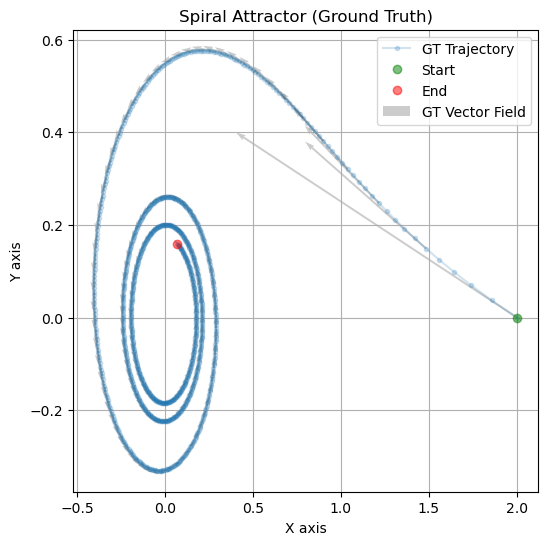

In [32]:
fig, ax = plot_trajectory_2D(ts, gt_trajectory, gt_gradients, title="Spiral Attractor (Ground Truth)")

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 16px; color: black; font-weight: bold;">
Create data batch by adding noise and sampling random points from the ground truth trajectory
</div>

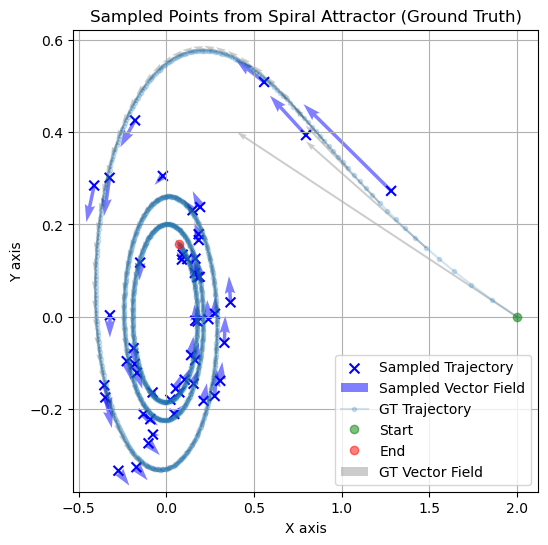

In [35]:
# ratio of points to sample from the entire trajectory
ratio = 0.05
n_points = int(ratio * n_steps)
indices = np.sort(np.random.choice(n_steps, n_points, replace=False))
sampled_ts = ts[indices]
sampled_trajectory = gt_trajectory[indices]
sampled_gradients = gt_gradients[indices]

# add noise to the sampled points
noise_level = 0.05
noise = noise_level * torch.randn_like(sampled_trajectory)
sampled_trajectory = sampled_trajectory + noise

fig, ax = plot_trajectory_2D(ts, gt_trajectory, gt_gradients, sampled_ts, sampled_trajectory, sampled_gradients, title="Sampled Points from Spiral Attractor (Ground Truth)")

In [36]:
# create batch data of noisy samples of ground truth trajectory
batch_size = 16

batch_ts = ts.unsqueeze(0).repeat((batch_size,1))
batch_gt_trajectory = gt_trajectory.unsqueeze(0).repeat((batch_size,1,1))
batch_gt_gradients = gt_gradients.unsqueeze(0).repeat((batch_size,1,1))

# indices to pick : (batch_size, n_points) array of indices
indices = np.sort(np.random.choice(n_steps, (batch_size, n_points), replace=True), axis=1)

# sample data
indices = torch.from_numpy(indices).long().to(ts.device)
batch_sampled_ts = ts[indices]
batch_sampled_trajectory = gt_trajectory[indices]
batch_sampled_gradients = gt_gradients[indices]

# add noise to the sampled points
noise_level = 0.05
noise = noise_level * torch.randn_like(batch_sampled_trajectory)
batch_sampled_trajectory = batch_sampled_trajectory + noise

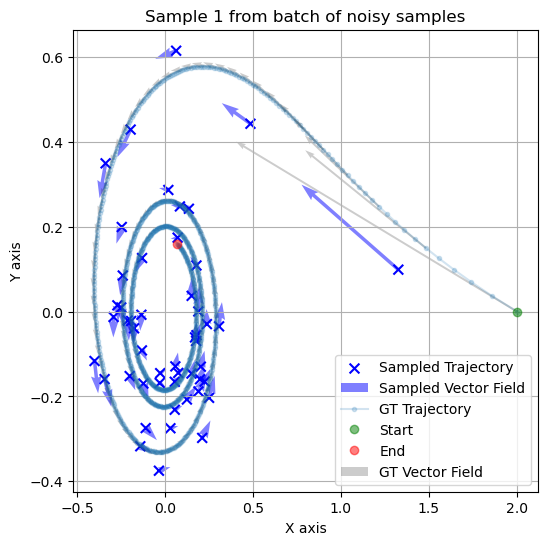

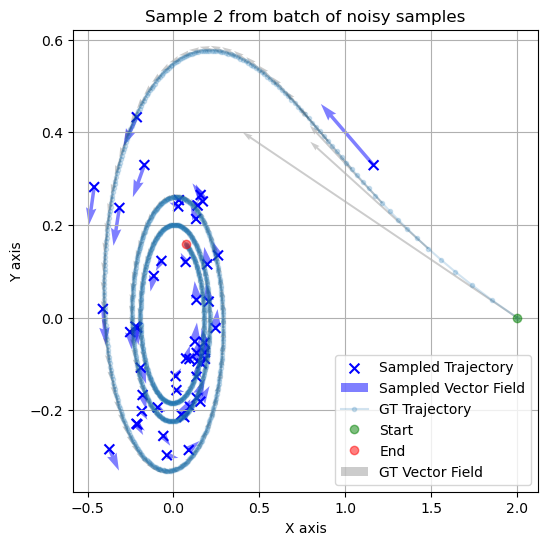

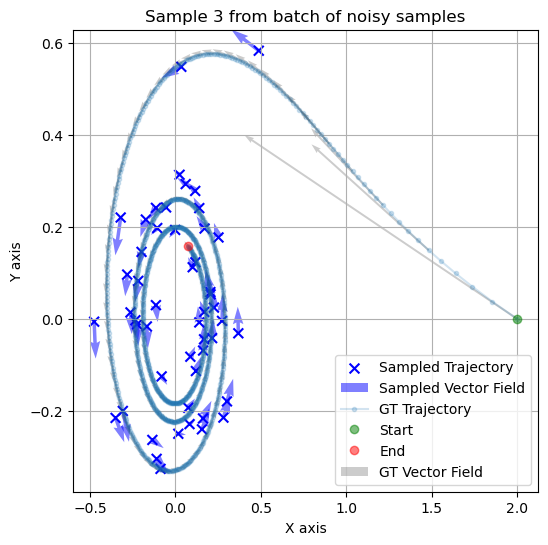

In [37]:
# display some samples
N = 3

for i in range(N):
    fig, ax = plot_trajectory_2D(batch_ts[i], batch_gt_trajectory[i], batch_gt_gradients[i], 
                                 batch_sampled_ts[i], batch_sampled_trajectory[i], batch_sampled_gradients[i], 
                                 title=f"Sample {i+1} from batch of noisy samples")
    plt.show()

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 28px; color: black; font-weight: bold;">
Model
</div>

from: [ArviX Latent ODEs for Irregularly-Sampled Time Series](https://arxiv.org/abs/1907.03907)

We want to learn the flow dynamics from the batch sampled data

![Alt text](/home/benjamin.deporte/MVA/MVA_Stage/images/Neural_ODE_01.png)

Parameters

In [38]:
Dx = 2  # dimension of the data
Dz = 4  # dimension of the latent space

Prior

In [ ]:
p_theta_z = MultivariateNormal(torch.zeros(Dz).to(device), torch.eye(Dz).to(device))
z0 = p_theta_z.sample((batch_size,))